In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import pickle
import os

# **Data Gatehring**

In [2]:
# Load the dataset
FILE_PATH = 'hf://datasets/ZhafranR/CC-ID-News/CCID-News-v1.csv'
data = pd.read_csv(FILE_PATH)

# Inspect the first few rows of the dataset
print(data.head())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


                                               Title  \
0  Bisik-bisik Menperin, Bus Listrik Juga Bakal D...   
1  Gak Tanggung-tanggung, Freeport Sediakan Rp54,...   
2  Begini Upaya PLN Siagakan Listrik untuk Tahun ...   
3  Wapres Soal Reshuffle: Kita Tunggu Saja, Terja...   
4  BMKG: Waspada Gelombang Laut 6 Meter & Banjir ...   

                                                 URL  \
0  https://www.cnbcindonesia.com/news/20221227173...   
1  https://www.cnbcindonesia.com/news/20221227161...   
2  https://www.cnbcindonesia.com/news/20221227172...   
3  https://www.cnbcindonesia.com/news/20221227155...   
4  https://www.cnbcindonesia.com/news/20221227160...   

                                               Image  \
0  https://awsimages.detik.net.id/visual/2022/10/...   
1  https://awsimages.detik.net.id/visual/2018/07/...   
2  https://awsimages.detik.net.id/visual/2022/12/...   
3  https://awsimages.detik.net.id/visual/2022/12/...   
4  https://awsimages.detik.net.id/visual/2020/

In [3]:
# Hapus kolom yang tidak digunakan
dataCleaned = data.drop(columns=['URL', 'Image', 'News Hour', 'News Portal'])

print(dataCleaned)

                                                     Title  \
0        Bisik-bisik Menperin, Bus Listrik Juga Bakal D...   
1        Gak Tanggung-tanggung, Freeport Sediakan Rp54,...   
2        Begini Upaya PLN Siagakan Listrik untuk Tahun ...   
3        Wapres Soal Reshuffle: Kita Tunggu Saja, Terja...   
4        BMKG: Waspada Gelombang Laut 6 Meter & Banjir ...   
...                                                    ...   
1101893    PBB prihatin pertempuran kembali pecah di Sudan   
1101894     17 orang tewas akibat jembatan ambruk di India   
1101895  Pawai Festival ASEAN akrabkan masyarakat denga...   
1101896         Biden tak akan hadiri KTT ASEAN di Jakarta   
1101897  China catatkan rekor terendah jumlah kasus kri...   

                                                 News Text         News Date  
0        Menteri Perindustrian (Menperin) Agus Gumiwang...  27 December 2022  
1        PT Freeport Indonesia (PTFI) diproyeksikan aka...  27 December 2022  
2        Guna mema

In [2]:
data = pd.read_csv('cleaned_news_data.csv')

# Membatasi data menjadi 20.000 baris pertama
df_cleaned_subset = data.head(20000)

# Menyimpan data yang telah dibatasi ke file CSV
df_cleaned_subset.to_csv('cleaned_news_data_subset.csv', index=False)

# Verifikasi bahwa file telah disimpan
print("Data yang dibatasi telah disimpan ke 'cleaned_news_data_subset.csv'")


Data yang dibatasi telah disimpan ke 'cleaned_news_data_subset.csv'


# **Model**

In [3]:
data = pd.read_csv('cleaned_news_data_subset.csv')

# Preprocess the text (cleaning and tokenizing)
texts = data['News Text'].astype(str).values

# Create a TextVectorization layer
vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode='int',
    output_sequence_length=500  # Can adjust this based on your data
)

# Adapt the vectorizer on the corpus (the text data)
vectorizer.adapt(texts)

# Convert texts into tokenized sequences
sequences = vectorizer(texts)

# Display the shape of the sequences
print(f"Tokenized sequences shape: {sequences.shape}")

Tokenized sequences shape: (20000, 500)


In [4]:
# Define the function to create features and labels for training
def features_and_labels_dataset(sequences, sequence_length=500):
    """
    Converts tokenized sequences into features and labels, then prepares them as a TensorFlow Dataset
    """
    # Create features and labels
    features = sequences[:, :-1]  # All tokens except the last
    labels = sequences[:, -1]  # Last token as the label

    # One hot encode labels
    one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=len(vectorizer.get_vocabulary()))

    # Create TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((features, one_hot_labels))

    return dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Prepare the dataset
dataset = features_and_labels_dataset(sequences)

# Check the shape of one batch of data
for features, label in dataset.take(1):
    print(f"Features shape: {features.shape}")
    print(f"Labels shape: {label.shape}")


Features shape: (32, 499)
Labels shape: (32, 186263)


In [5]:
# Define the model architecture
def create_model(vocab_size, max_sequence_length):
    """
    Creates a simple neural network model for text classification using an LSTM layer.

    Args:
        vocab_size (int): Size of the vocabulary.
        max_sequence_length (int): Length of input sequences.

    Returns:
        tf.keras.Model: The model to train.
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(max_sequence_length-1,)),  # Input layer
        tf.keras.layers.Embedding(vocab_size, 100),  # Embedding layer
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),  # Bidirectional LSTM layer
        tf.keras.layers.Dense(64, activation='relu'),  # Dense layer
        tf.keras.layers.Dense(vocab_size, activation='softmax')  # Output layer
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Get the total vocab size and max sequence length
vocab_size = len(vectorizer.get_vocabulary())
max_sequence_length = 500  # Set according to your sequence length

# Create the model
model = create_model(vocab_size, max_sequence_length)

# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 499, 100)          18626300  
                                                                 
 bidirectional (Bidirection  (None, 256)               234496    
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 186263)            12107095  
                                                                 
Total params: 30984339 (118.20 MB)
Trainable params: 30984339 (118.20 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
# Calculate the number of samples for validation
val_size = int(len(sequences) * 0.2)

num_shards = 2 # number of shards
shard_index_val = 0 # shard index for validation
shard_index_train = 1 # shard index for training

# Create validation dataset
val_dataset = dataset.shard(num_shards=num_shards, index=shard_index_val)

# Create training dataset
train_dataset = dataset.shard(num_shards=num_shards, index=shard_index_train)

# Train the model using the split datasets
history = model.fit(train_dataset, epochs=10, batch_size=32, validation_data=val_dataset)

Epoch 1/10
312/312 [==============================] - 253s 803ms/step - loss: 1.9569 - accuracy: 0.9139 - val_loss: 0.9472 - val_accuracy: 0.9127
Epoch 2/10
312/312 [==============================] - 240s 771ms/step - loss: 0.6449 - accuracy: 0.9164 - val_loss: 0.9221 - val_accuracy: 0.9127
Epoch 3/10
312/312 [==============================] - 240s 769ms/step - loss: 0.5566 - accuracy: 0.9165 - val_loss: 0.9803 - val_accuracy: 0.9136
Epoch 4/10
312/312 [==============================] - 240s 769ms/step - loss: 0.5365 - accuracy: 0.9169 - val_loss: 1.0510 - val_accuracy: 0.9136
Epoch 5/10
312/312 [==============================] - 241s 772ms/step - loss: 0.5239 - accuracy: 0.9177 - val_loss: 1.0436 - val_accuracy: 0.9130
Epoch 6/10
312/312 [==============================] - 240s 770ms/step - loss: 0.5116 - accuracy: 0.9183 - val_loss: 1.1384 - val_accuracy: 0.9122
Epoch 7/10
312/312 [==============================] - 241s 773ms/step - loss: 0.4887 - accuracy: 0.9178 - val_loss: 1.2684 -

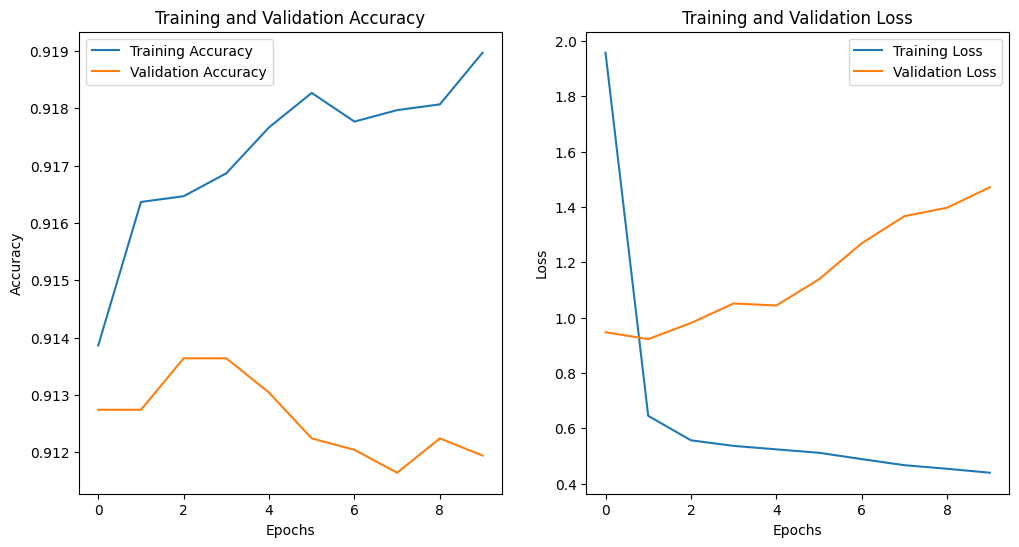

In [11]:
# Plotting training and validation accuracy and loss
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss.

    Args:
        history: History object returned by model.fit().
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    # Plot accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot the results
plot_training_history(history)


In [13]:
# Evaluate the model on the validation data
val_loss, val_accuracy = model.evaluate(dataset, verbose=1)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

625/625 [==============================] - 116s 185ms/step - loss: 1.0044 - accuracy: 0.9154
Validation Loss: 1.0044126510620117
Validation Accuracy: 0.9154000282287598


In [14]:
# Use the model to make predictions on new, unseen data
def predict_hoax(model, input_text, vectorizer, max_sequence_len):
    """
    Predicts whether a given text is a hoax or not using the trained model.

    Args:
        model: The trained model.
        input_text: The text to predict on.
        vectorizer: The text vectorizer used for preprocessing the input.
        max_sequence_len: The maximum sequence length for padding.

    Returns:
        prediction (str): "Hoax" or "Not Hoax" based on the model's output.
    """
    # Preprocess the input text
    tokenized_input = vectorizer(input_text)
    padded_input = tf.keras.utils.pad_sequences([tokenized_input], maxlen=max_sequence_len-1, padding='pre')

    # Make the prediction
    prediction = model.predict(padded_input)
    predicted_class = np.argmax(prediction, axis=-1).item()

    # Return the prediction based on the output class
    if predicted_class == 1:
        return "Hoax"
    else:
        return "Not Hoax"

In [16]:
# Save the model architecture in JSON format
model_json = model.to_json()
with open("hoax_detection_model.json", "w") as json_file:
    json_file.write(model_json)

# Save the model weights in H5 format
model.save_weights("hoax_detection_model_weights.h5")

print("Model saved in JSON and H5 formats.")

Model saved in JSON and H5 formats.
